# Demo: estimating the parameter for a biased coin

Here we are going to look at the simple forms of Bayesian inference we've talked about so far, for the coin-flipping example.

The model is as follows:

$$\begin{align*}
\mu &\sim \mathrm{Uniform}([0, 1]) \\
x_i &\sim \mathrm{Bernoulli}(\mu)
\end{align*}$$

for $i = 1,\dots,N$ trials.

We are interested in answering questions like:

* After N coin flips, with a certain number of heads, what's the probability that the next flip comes up heads as well?
* What is the probability that this coin will come up heads more than 40% of the time?
* What is the probability that this coin will come up heads more than 60% of the time?

This notebook will demo doing this using the inference methods covered in the first two weeks.

In [1]:
import torch
import torch.distributions as dist
from monte_carlo import MonteCarlo as MC 

import numpy as np
import math

import matplotlib.pyplot as plt
%matplotlib inline

## Define some hypothetical data

We will use `1` and `0` instead of heads and tails. Here is some hypothetical data, which we will put in a torch tensor of length $N$.

In [2]:
x = torch.FloatTensor([1, 0, 0, 1, 1, 0 ,1 ,0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1])

print("Number of trials:", len(x))
print("Number of heads:", x.sum().item())
print("Empirical probability = ", round( (x.sum() / len(x)).item() , 3)  )

Number of trials: 21
Number of heads: 13.0
Empirical probability =  0.619


## Define the joint distribution

We're going to write a function which evaluates the joint probability distribution of the prior, and all the observations, i.e. $p(\mu, x_1, \dots, x_N)$. All our inference methods will depend on this function.

We will use the `torch.distributions` library for this.

Also, we will work in **logarithms** for reasons of numeric stability!

In [3]:
def log_joint(mu, x):
    """ Evaluate log p(mu, x) """

    # p(mu)
    log_prior = dist.Uniform(0, 1, validate_args=False).log_prob(mu)
    
    # p(x1, …, xN | mu)
    log_likelihood = dist.Bernoulli(mu).log_prob(x).sum(0)

    return log_prior + log_likelihood

### Plot the log joint for different $\mu$

Since this is a one-dimensional problem, it's easy to just look at the log joint distribution!

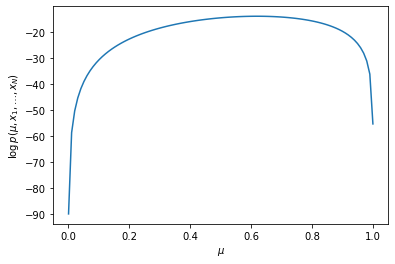

In [4]:
domain = np.linspace(0.001,0.999,100)

plt.plot(domain, [log_joint(mu, x) for mu in domain])
plt.xlabel('$\mu$')
plt.ylabel('$\log p(\mu, x_1, \dots, x_N)$');


If it helps for visualization, we can expontentiate this result to see a distribution which is unnormalized, but which is proportional to the posterior distribution of $\mu | \boldsymbol{x}$.

Also, note that here we use a different approach to evaluate across all the values in the `domain`, from 0 to 1. This is a *vectorized* approach, which will be faster than `for` loops for large data. It's always important to double-check your vectorized code is correct though! Sometimes it's good to write the slow version first...

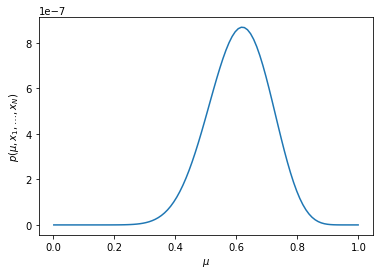

In [5]:
plt.plot(domain, log_joint(torch.FloatTensor(domain), x[:,None]).exp())
plt.xlabel('$\mu$')
plt.ylabel('$p(\mu, x_1, \dots, x_N)$');



## Importance sampling

A simple importance sampling algorithm draws simulations from a proposal, and then weights them in order to approximate a target distribution (e.g. an unnormalized posterior).

Here we will use a uniform distribution on $[0, 1]$ as a simple proposal.

Let's draw 5,000 samples, and plot a histogram. (Setting `density=True` normalizes the y-axis on the histogram, instead of displaying counts.)

tensor([0.4203, 0.4677, 0.4237,  ..., 0.8340, 0.9332, 0.9586])


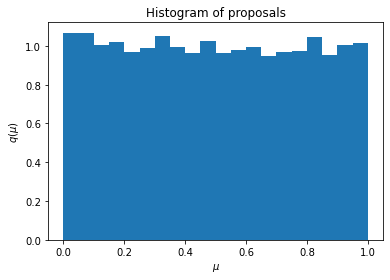

In [6]:
proposal_dist = dist.Uniform(0, 1)

proposal_samples = proposal_dist.sample((20000,))
plt.hist(proposal_samples.numpy(), bins=20, density=True);
plt.xlabel("$\mu$")
plt.ylabel("$q(\mu)$")
plt.title("Histogram of proposals");
print(proposal_samples)

Compute unnormalized log weights as
$$\log w(\mu) = \log \frac{p(\boldsymbol{x} | \mu)p(\mu)}{q(\mu)}$$

In [7]:
log_unnormalized_weights = log_joint(proposal_samples, x[:,None]) - proposal_dist.log_prob(proposal_samples)

When normalizing log values, sometimes there can be numeric underflow issues. We generally want to compute

$$W_i = \frac{e^{z_i}}{\sum_{j} e^{z_j}}$$

where $z_i = \log w_i$. The problem is that exponents of very negative values can all be zero, numerically, and exponents of large values can be infinity!

To deal with this, we generally like to use the "`logsumexp`" trick. It's based on the following identity:

$$\log \sum_{j} \exp({z_j}) = C + \log \sum_j \exp ({z_j} - C)$$

for any arbitrary constant $C$. We can then set $C = \max_j z_j$ in order to ensure that the largest value in the exponent is $\exp(0) = 1$.

Fortunately, in pytorch there is a nice function that we can use without having to manually compute the maximum.

In [8]:
log_normalized_weights = log_unnormalized_weights - torch.logsumexp(log_unnormalized_weights, dim=-1)
weights = log_normalized_weights.exp()
print("Confirm that the normalized weights sum to 1:", weights.sum())


Confirm that the normalized weights sum to 1: tensor(1.0000)


To visualize the weighted samples, we can actually just pass the weights as an extra argument to the histogram function:

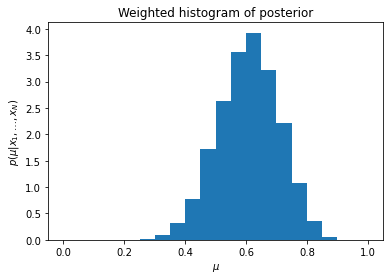

In [9]:
plt.hist(proposal_samples.numpy(), weights=weights.numpy(), bins=20, density=True);
plt.xlabel("$\mu$")
plt.ylabel("$p(\mu | x_1,\dots,x_N)$")
plt.title("Weighted histogram of posterior");


### Answering questions about the posterior

We "answer questions" by computing

$$E_{p(\mu | \boldsymbol{x})}[f(\mu)] \approx \sum_{i} W_i f(\mu^{(i)})$$

for our samples $\mu^{(i)}$ with weights $W_i$.

The choice of function $f$ determines what we are "asking" our posterior.

In [10]:
expected_value_of_mu = weights @ proposal_samples

print("What is the probability the next flip is heads?\n", expected_value_of_mu.item())

What is the probability the next flip is heads?
 0.6079607009887695


In [11]:
# we can write down "indicator" functions using logical operators as follows:
prob_lt_40 = weights @ (proposal_samples < 0.4).float()

print("What is the probability that <40% of flips are heads?\n", prob_lt_40.item())

What is the probability that <40% of flips are heads?
 0.02219003066420555


In [12]:
prob_gt_60 = weights @ (proposal_samples > 0.6).float()

print("What is the probability that >60% of flips are heads?\n", prob_gt_60.item())

What is the probability that >60% of flips are heads?
 0.5427870154380798


In [13]:
# lots of ways of coding this, just one example…
prob_between_25_75 = weights @ ((proposal_samples - 0.5).abs() < 0.25).float()

print("What is the probability that \mu is in the range (0.25, 0.75)?\n", prob_between_25_75.item())

What is the probability that \mu is in the range (0.25, 0.75)?
 0.9250292778015137


## What is the marginal likelihood?

We can estimate the normalizing constant of the joint distribution by taking the average of the unnormalized weights.

Since this is a one-dimensional problem, we can actually plot the log joint from before, now "normalized".

Note how the y-axis matches the density of the weighted histogram.

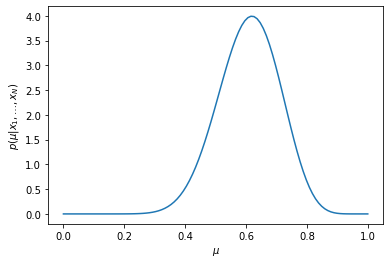

In [14]:
Z_hat = (log_unnormalized_weights.logsumexp(-1) - np.log(len(log_unnormalized_weights))).exp()


plt.plot(domain, log_joint(torch.FloatTensor(domain), x[:,None]).exp() / Z_hat)
plt.xlabel('$\mu$')
plt.ylabel('$p(\mu | x_1, \dots, x_N)$');


## MCMC alternative

We'll also demo this using MCMC. This is a very simple, basic MCMC algorithm that we'll run here, that isn't very efficient. But it should get the idea across.

In [15]:
def MCMC_step(current_mu, data, proposal_std):
    
    proposal = dist.Normal(current_mu, proposal_std)
    candidate = proposal.sample()
    
    try:
        p_new = log_joint(candidate, data)
    except ValueError:
        p_new = -torch.inf
    p_old = log_joint(current_mu, data)
    
    if p_new - p_old > torch.rand(1).log().item():
        return candidate, 1
    else:
        return current_mu, 0
    
def run_chain(init, num_steps, proposal_std):
    """ Returns a sequence of samples, and the acceptance rate """
    mu_chain = [torch.scalar_tensor(init)]
    accepted = 0
    for step in range(num_steps):
        mu, accept = MCMC_step(mu_chain[-1], x, proposal_std)
        mu_chain.append(mu)
        accepted += accept
    return np.array(mu_chain), accepted / num_steps

Acceptance rate: 0.494


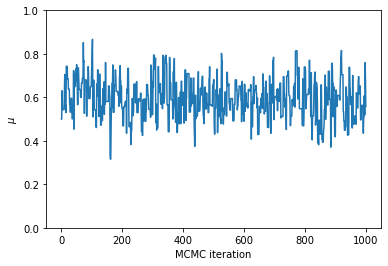

In [16]:
chain, acceptance_rate = run_chain(0.5, 1000, proposal_std=0.2)

print("Acceptance rate:", acceptance_rate)
plt.plot(chain);
plt.ylim(0, 1);
plt.xlabel("MCMC iteration")
plt.ylabel('$\mu$');

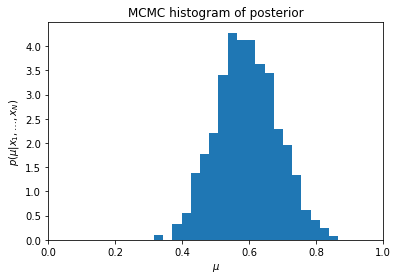

In [17]:
plt.hist(chain, bins=20, density=True);
plt.xlim(0, 1)
plt.xlabel("$\mu$")
plt.ylabel("$p(\mu | x_1,\dots,x_N)$")
plt.title("MCMC histogram of posterior");

### Note: what if we chose a different proposal?

Here's what happens if we take very large steps with each proposal.

Acceptance rate: 0.15


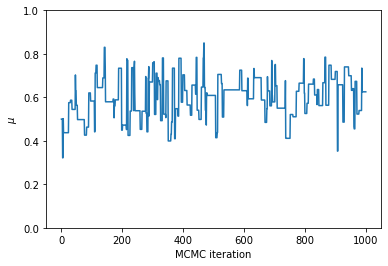

In [18]:
chain, acceptance_rate = run_chain(0.5, 1000, proposal_std=1.0)
print("Acceptance rate:", acceptance_rate)
plt.plot(chain)
plt.ylim(0, 1);
plt.xlabel("MCMC iteration")
plt.ylabel('$\mu$');

Alternatively, if we choose a very small proposal:

Acceptance rate: 0.959


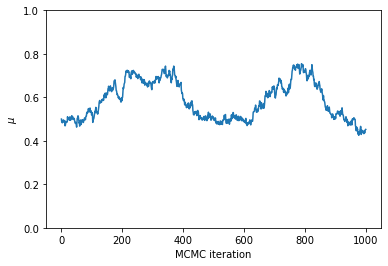

In [19]:
chain, acceptance_rate = run_chain(0.5, 1000, proposal_std=0.01)

print("Acceptance rate:", acceptance_rate)
plt.plot(chain)
plt.ylim(0, 1);
plt.xlabel("MCMC iteration")
plt.ylabel('$\mu$');

# Calculate Expectancies, Probabilites, and Variance with Importance Sampling

In [20]:
squared_difference = []
# changing number of samples
for i in range(1,6):
    monte_carlo = MC(10**i, 10)
    squared_difference.append(monte_carlo.compute_squared_difference())
    print(f'(μ - P(H))^2 = {squared_difference[-1]}')
    print('\n')

μ = 0.5
P(H) = 0.504207193851471
(μ - P(H))^2 = 1.7700480384519324e-05


μ = 0.5
P(H) = 0.4879039525985718
(μ - P(H))^2 = 0.00014631435624323785


μ = 0.5
P(H) = 0.498791366815567
(μ - P(H))^2 = 1.4607941238864441e-06


μ = 0.5
P(H) = 0.5014947056770325
(μ - P(H))^2 = 2.2341450858220924e-06


μ = 0.5
P(H) = 0.4994663596153259
(μ - P(H))^2 = 2.8477205660237814e-07




In [21]:
squared_difference = []
# changing number of observations
for i in range(1,6):
    monte_carlo = MC(500, 10*i)
    squared_difference.append(monte_carlo.compute_squared_difference())
    print(f'(μ - P(H))^2 = {squared_difference[-1]}')
    print('\n')

μ = 0.5
P(H) = 0.4918345510959625
(μ - P(H))^2 = 6.667455454589799e-05


μ = 0.5
P(H) = 0.4893566370010376
(μ - P(H))^2 = 0.00011328117398079485


μ = 0.4000000059604645
P(H) = 0.4035224914550781
(μ - P(H))^2 = 1.2407904250721913e-05


μ = 0.5
P(H) = 0.49990564584732056
(μ - P(H))^2 = 8.902706127855708e-09


μ = 0.46000000834465027
P(H) = 0.46460095047950745
(μ - P(H))^2 = 2.1168669263715856e-05




In [22]:
monte_carlo.percentage_greater_than_prob(0.4).item()

0.8280639052391052

In [23]:
monte_carlo.percentage_less_than_prob(0.4).item()

0.1719369888305664